<a href="https://colab.research.google.com/github/amitdamri/FastAI-Repo/blob/main/FastAI_Bears_Classification_APP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Set and Test Environment 

In [1]:
%%capture
import os
import requests 
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *

In [2]:
key = os.environ.get('AZURE_SEARCH_KEY', '6bc818a814604cfa87ff288be8d11012')

In [3]:
def search_images_bing(key, term, min_sz = 128, max_images = 150):
  search_url = "https://api.bing.microsoft.com/v7.0/images/search"
  headers = {"Ocp-Apim-Subscription-Key" : key}
  params  = {"q": term, "count": max_images, "min_height": min_sz, 'min_width': min_sz, "textDecorations":True, "textFormat":"HTML"}
  response = requests.get(search_url, headers=headers, params=params)
  response.raise_for_status()
  search_results = response.json()
  return L(search_results['value'])

In [ ]:
term = 'grizzly bear'
results = search_images_bing(key, term)
ims = results.attrgot('contentUrl')
len(ims)

150

In [ ]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

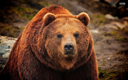

In [ ]:
im = Image.open(dest)
im.to_thumb(128,128)

Evevrything works! Download all images

In [4]:
bear_types = 'grizzly', 'black', 'teddy'
path = Path('bears')

if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        print(dest)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

bears/grizzly
bears/black
bears/teddy


In [5]:
fns = get_image_files(path)
fns

(#429) [Path('bears/black/f43a7365-7fa1-4a17-8408-36433674e658.jpg'),Path('bears/black/7e70b08a-a9c5-45e2-8dfc-75827a0f5ebd.jpg'),Path('bears/black/0d99822c-3c85-4c8b-8f69-5f14430c3a33.jpg'),Path('bears/black/d4195ded-2263-4c42-b236-5d227b38839b.jpg'),Path('bears/black/03a5e377-3de5-4609-a723-c2af5240ef04.jpg'),Path('bears/black/88ce7d2e-1386-4143-82d7-1429968c4712.jpg'),Path('bears/black/838ec9d2-2577-4966-97f2-c8d7278e258b.jpg'),Path('bears/black/151ebd28-c724-40c5-ba1e-5c658e884f85.jpg'),Path('bears/black/8c63ded3-1211-4d97-983e-6053b662e5b6.jpg'),Path('bears/black/e0466603-2508-47f2-9a05-dfeb2f38f07a.jpg')...]

In [6]:
failed = verify_images(fns)
print(len(failed))
failed.map(Path.unlink)

8


(#8) [None,None,None,None,None,None,None,None]

In [ ]:
help(DataBlock)

Build DataBlock

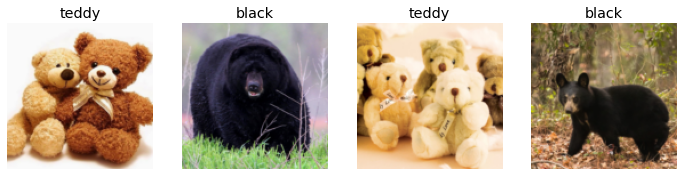

In [19]:
bears = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.2, seed = 42),
    get_y = parent_label,
    item_tfms=Resize(128)
)

dls = bears.dataloaders(path)
dls.valid.show_batch(max_n = 4, nrows = 1)

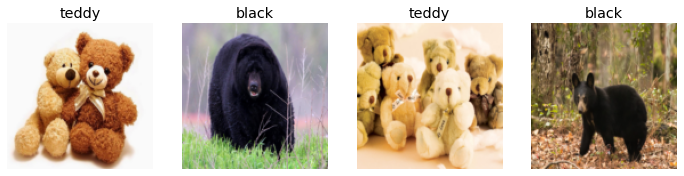

In [20]:
bears = bears.new(item_tfms = Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n = 4, nrows = 1)

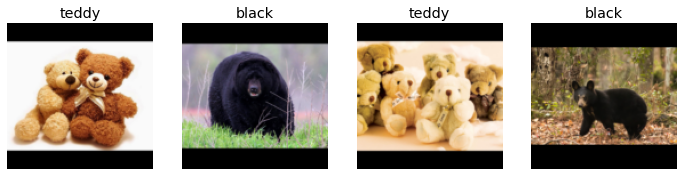

In [22]:
bears = bears.new(item_tfms = Resize(128, ResizeMethod.Pad, pad_mode = 'zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n = 4, nrows = 1)

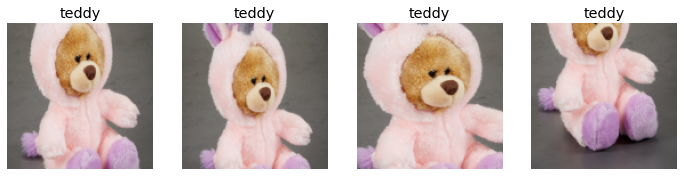

In [24]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale = 0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n = 4, nrows = 1, unique = True)

Data Augmentation

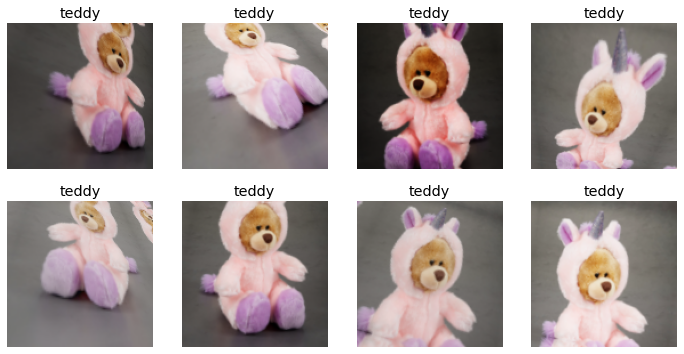

In [25]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n = 8, nrows = 2, unique = True)

Train image classifier

In [26]:
bears = bears.new(
    item_tfms = RandomResizedCrop(224, min_scale = 0.5),
    batch_tfms = aug_transforms()
)
dls = bears.dataloaders(path)

learn = vision_learner(dls, resnet18, metrics = error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.290625,0.106347,0.023810,00:26


epoch,train_loss,valid_loss,error_rate,time
0,0.124252,0.068880,0.035714,00:45
1,0.120982,0.040725,0.023810,00:35
2,0.086903,0.033076,0.023810,00:34
3,0.070963,0.039262,0.023810,00:27


Interpret the results

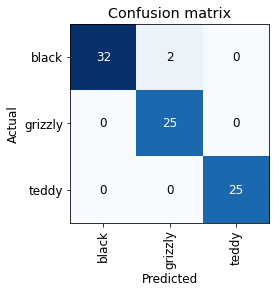

In [27]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [32]:
??interp.plot_top_losses

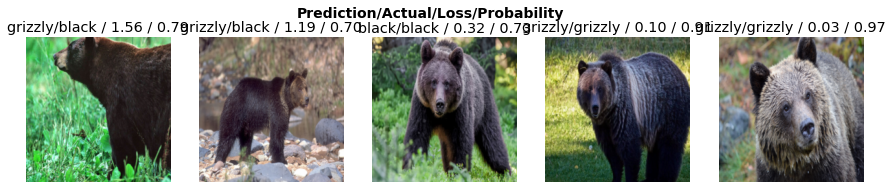

In [35]:
interp.plot_top_losses(5, nrows = 1)

Clean data

In [36]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [37]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [38]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Deploy

In [39]:
learn.export()

In [41]:
path = Path()
path.ls(file_exts = '.pkl')

(#1) [Path('export.pkl')]

In [42]:
learn_inf = load_learner(path/'export.pkl')
learn_inf.predict('bears/grizzly/00517739-9465-4d54-88a7-f604abcf0d9d.jpg')

('grizzly', TensorBase(1), TensorBase([1.1701e-06, 1.0000e+00, 2.1614e-06]))

In [43]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [44]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [45]:
img = PILImage.create(btn_upload.data[-1])

In [49]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [52]:
pred, pred_idx, probs = learn_inf.predict(img)
lbl_pred = widgets.Label()
lbl_pred.value = f"Prediction: {pred}; Probability: {probs[pred_idx]:.04f}"
lbl_pred

Label(value='Prediction: grizzly; Probability: 1.0000')

In [53]:
btn_run = widgets.Button(description = 'Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [54]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [55]:
btn_upload = widgets.FileUpload()
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

Use new notebook to turn into a real app!

# Try Debugger

In [12]:
!python --version

Python 3.8.16


In [ ]:
# import pdb; pdb.set_trace()
# breakpoint()
# %debug

In [ ]:
f = "test"
breakpoint()
print(f"test = {f}")

In [ ]:
def add(a, b):
  """This is the doc"""
  c = a + b
  return c

a = 1
b = 2 
breakpoint()
c = add(a, b)